In [ ]:
%matplotlib notebook
%matplotlib notebook

# load GB ANN libraries
import os
os.sys.path.append('../src')

import utils as ut
import CSTR_model as gb_ann
import custom_layers as cl

# Dependencies
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats as sps
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


# Grey box packages

# Plotting options
sns.set_style('ticks')
cm = plt.get_cmap("viridis")
sns.set_context('paper')
np.random.seed(seed=20)
blue = sns.color_palette()[0]
green = sns.color_palette()[2]
red = sns.color_palette()[3]
yellow = sns.color_palette()[4]

# Enable eager for interactive tensorflow session
tf.enable_eager_execution()

# seed for reproduceability
np.random.seed(1234)

In [ ]:
# Michaelis Menten Model to generate data

kcat = 0.14 # 1/s
Km = 1.5e-2 # mol/L
D = .05 # 1/s
theta = 1/D
S0 = 3e-2 # mole/L

def ode(t,U,E0_fun):
    
    
    E0  = E0_fun(t)
            
    S  = U[0]
    P  = U[1]
    E  = U[2]
    
    rate = kcat*E*S/(Km+S)
    
    F = np.array([ (S0 - S)/theta - rate,
                   -P/theta + rate,
                  (E0 - E)/theta
    ])
    
    
    return F

In [ ]:
# Data generation parameters
simulation_time = 1800             
sample_time = 1   
switch_time = 60
N_online_steps= int(simulation_time/sample_time)+1  # number of online measurements betweens steps

t_sim = np.linspace(0,simulation_time,N_online_steps)
    
N_switches = int(simulation_time/switch_time)+10
switch_times = np.cumsum(np.ones(N_switches)*switch_time)
E0_steps = np.random.uniform(0,1e-2,size=(N_switches,1))

def E0fun(t):
    try:
        return E0_steps[t<switch_times][0]
    except:
        print('time failed at:', t)
        return .5


E0s = np.zeros(N_online_steps)
for i in range(len(t_sim)):
    E0s[i] = E0fun(t_sim[i])

    
    

# All states full time series
x_on = np.zeros((N_online_steps,3))

# All states full time series
u_on = np.zeros((N_online_steps,1))

# Unknown, but to be learned, parameter
phi_on = np.zeros((N_online_steps,1))

In [4]:
# Generate data
x0 = np.array([5e-2, 5e-2, 5e-3])
t_init = np.linspace(0,200,20)
x,infodict = spi.odeint(lambda x,t : ode(t,x,lambda t:.5e-2), x0,t_init,full_output=True)
x0 = x[-1]

integrator = spi.ode(lambda t,x : ode(t,x,E0_fun=E0fun))
integrator.set_initial_value(x0)
integrator.set_integrator('vode')


for i in range(N_online_steps):
    if i > 0:
        integrator.integrate(t_sim[i])

    #print(integrator.y)
    u_on[i] = E0fun(t_sim[i])
    noise = np.random.normal(0,1,3)
    noise = noise*(.02*x_on[i-1])
    x_on[i] = integrator.y+noise*0
    phi_on[i] = kcat*integrator.y[2]*integrator.y[0]/(Km+integrator.y[0])
  


<IPython.core.display.Javascript object>


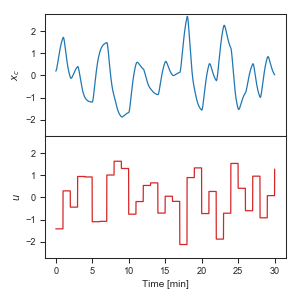

In [5]:

'''# Plot data
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(t_sim,sps.zscore(x_on))
plt.ylim(-3.5,3.5)
plt.ylabel(r'$\{S,P,E\}$')
plt.legend(['S', 'P', 'E'],frameon=True, loc='upper right')
plt.subplot(312)
plt.plot(t_sim,sps.zscore(u_on))
plt.ylabel(r'E$_0$')


plt.subplot(313)
plt.plot(t_sim,sps.zscore(phi_on))
plt.ylabel(r'$k$')
plt.xlabel('Time (seconds)')

plt.tight_layout()
#plt.savefig('MM_Data.svg')
'''

fig=plt.figure(figsize=(4,4))
ax1=fig.add_subplot(211)
plt.plot(t_sim/60,sps.zscore(x_on.T[0]),c=blue)
ax1.set_ylabel(r'$x_c$')
ax1.set_ylim([-2.75,2.75])

ax2=fig.add_subplot(212,sharex=ax1)
plt.plot(t_sim/60,sps.zscore(u_on),c=red)
ax2.set_ylim([-2.75,2.75])


ax2.set_ylabel(r'$u$')

ax2.set_xlabel('Time [min]')
plt.tight_layout()
fig.subplots_adjust(hspace=0)
#plt.savefig('../figs/michaelis_training_data.svg')

In [6]:
# collect data in format for GB-ANN model
n_var = 2 # 2 variables (E0 and S) in the model
x_k = x_on[:,0].reshape(N_online_steps,1) # x_k = S[k]
u_k = u_on.reshape(N_online_steps,1)      # u_k = E0[k]
z_k = np.hstack([u_k,x_k])                # z_k = [u_k,x_k]
phi_k = phi_on.reshape(N_online_steps,1)  # the (to be learned) rate constant

mean_x   = np.mean(x_k)
s_x      = np.std(x_k)
mean_u   = np.mean(u_k)
s_u      = np.std(u_k)
mean_z   = np.array([mean_u, mean_x])
s_z      = np.array([s_u, s_x])
mean_phi = np.mean(phi_k) # could use estimate here in absense of underlying data
s_phi    = np.std(phi_k)

# standardize the data
xs_k = (x_k - mean_x)/s_x
us_k = (u_k - mean_u)/s_u
zs_k = np.hstack([us_k,xs_k])
# embed the data
lag = 1
embed = 31

# for simple notation, use ze_k for standardized embedded z (don't need unstandardized form)
ze_k = ut.embed_data(zs_k,lag,embed)
points = np.arange((embed-1)*lag,N_online_steps)

# save sample time tensor
sample_time_tensor = sample_time*tf.ones([len(points),1])

# discard data before enough collected for embedding
xs_k = xs_k[points]
us_k = us_k[points]
zs_k = zs_k[points]

lag_in_model = 10

In [7]:
# compare with black box model
bb_in = tf.keras.Input(shape=(embed*n_var,))
selector = cl.column_selector_layer(lag_in_model,embed,n_var)
selected = selector(bb_in)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(selected)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
bb_next = tf.keras.layers.Dense(1)(h)


In [ ]:
# Test effect of training size
ERRORS = np.zeros((4,4,20)) # dims are model type/error type, n_train, and repeats
training_points = np.array([100,500,1000,1500])
for j in range(len(training_points)):
    N_train = training_points[j]
    print(N_train)
    k=0
    while k<20:
        ze_k_train = tf.to_float(ze_k[0:N_train])
        x_train    = tf.to_float(xs_k[1:N_train+1])
        st_train   = sample_time_tensor[0:N_train]

        ze_k_valid = tf.to_float(ze_k[N_train:-1])
        x_valid    = tf.to_float(xs_k[N_train+1::])
        st_valid   = sample_time_tensor[N_train:-1]

        
        #delete before retraining
        try:
            del Balance_Model
        except:
            pass
        Balance_Model = gb_ann.CSTR_GB_ANN(theta,S0,mean_z,s_z,mean_phi,s_phi,lag_in_model,embed)
        ft =  Balance_Model.fit([ze_k_train,st_train],x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data=([ze_k_valid,st_valid], x_valid)
                                )
        #pd.DataFrame(ft.history).plot()
        # delete before retraining
        try:
            del BlackBox
        except:
            pass 
        BlackBox = tf.keras.Model(inputs=bb_in,outputs=bb_next)
        BlackBox.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),loss=tf.losses.mean_squared_error)
        ft_bb =  BlackBox.fit(ze_k_train,x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data = (ze_k_valid, x_valid)
                                )
        #pd.DataFrame(ft_bb.history).plot() 
        # Integrate the Model

        history0 = tf.reshape(tf.to_float(ze_k[0,n_var::]),[1,embed*n_var-n_var])
        xk0      = tf.reshape(tf.to_float(xs_k[0]),[1,1])
        uk0      = tf.reshape(tf.to_float(us_k[0]),[1,1])

        xkmodel = np.zeros([len(points),1])
        history = np.zeros([len(points),embed*n_var-n_var])
        xkmodel[0,:] = xk0
        history[0,:] = history0

        xkbbmodel = xkmodel.copy()
        historybb = history.copy()
        for i in range(len(points)):
            if i > 0:
                (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k[i-1],xkmodel[i-1],history[i-1])
                zek_bb = tf.reshape(tf.concat([tf.to_float(us_k[i-1]),
                                   tf.to_float(xkbbmodel[i-1]),
                                   tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
                xkbbmodel[i,:] = BlackBox(zek_bb)
                historybb[i] = zek_bb[:,0:embed*n_var-n_var]
        phi_model = Balance_Model.constitutive_law(us_k,xkmodel,history)

        ERRORS[0,j,k] = Balance_Model.CSTR_GB_ANN_model.evaluate([ze_k_valid,st_valid], x_valid,verbose=False)
        ERRORS[1,j,k] = BlackBox.evaluate(ze_k_valid,x_valid,verbose=False)
        ERRORS[2,j,k] = np.mean((xkmodel[N_train::]-xs_k[N_train::])**2)
        ERRORS[3,j,k] = np.mean((xkbbmodel[N_train::]-xs_k[N_train::])**2)
        print(ERRORS[:,j,k])
        if any(ERRORS.flatten()>10) or any(np.isnan(ERRORS.flatten())):
            k -=1
            print('outlier control')
        k+=1
        

In [ ]:

a

In [ ]:
print(MSE_MEDIAN)
print(MSE_STD)
print(MSE_QUANTS[0].T)
print(MSE_QUANTS[1].T)

In [ ]:
plt.errorbar?

In [ ]:


eval_data = pd.DataFrame(columns = ['GB Off-line', 'BB Off-line', 'GB On-line', 'BB On-line',
                                   'GB_OFF_STD', 'BB_OFF_STD', 'GB_ON_STD', 'BB_ON_STD',
                                   'GB_OFF_LQ', 'BB_OFF_LQ', 'GB_ON_LQ', 'BB_ON_LQ',
                                   'GB_OFF_UQ', 'BB_OFF_UQ', 'GB_ON_UQ', 'BB_ON_UQ',],
                         index = training_points,
                         data=np.hstack([MSE_MEDIAN,MSE_STD,MSE_QUANTS[0].T,MSE_QUANTS[1].T]))
fig=plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax.semilogy(eval_data['GB On-line'],'-o',c='grey')
#ax.semilogy(eval_data['BB On-line'],'-o',c='black')
#ax.semilogy(eval_data['GB Off-line'],'--o',c='grey')
#ax.semilogy(eval_data['BB Off-line'],'--o',c='black')
plt.errorbar(eval_data.index,eval_data['GB On-line'],yerr=np.array([eval_data['GB_ON_LQ'],eval_data['GB_ON_UQ']]), fmt='-o',c='grey',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['BB On-line'],yerr=np.array([eval_data['BB_ON_LQ'],eval_data['BB_ON_UQ']]), fmt='-o',c='black',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['GB Off-line'],yerr=np.array([eval_data['GB_OFF_LQ'],eval_data['GB_OFF_UQ']]), fmt='--o',c='grey',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['BB Off-line'],yerr=np.array([eval_data['BB_OFF_LQ'],eval_data['BB_OFF_UQ']]), fmt='--o',c='black',capsize=1.5)

#ax.plot(x=training_points,y=eval_data['BB On-line'],'--o',c='black',label='asdfasdf')
#ax.plot(x=training_points,y=eval_data['GB Off-line'],ls='--o',c='grey',label='43434')
#ax.plot(x=training_points,y=eval_data['BB Off-line'],ls='--o',c='black',label='123412')
ax.set_yscale('log')
ax.set_xlabel('Number of Training Data Samples')
ax.set_ylabel('Mean Squared Error (Validation Data)')
plt.tight_layout()
#plt.ylim([1e-6,1e2])
plt.legend()
#plt.savefig('../figs/MM_valid_error_w_bars.svg')

In [8]:
# Test effect of delay time
ERRORS = np.zeros((4,4,20)) # dims are model type/error type, n_train, and repeats
training_points = 500
lag_times = np.array([5,10,15,20])
for j in range(len(lag_times)):
    N_train = training_points
    print(N_train)
    k=0
    lag_in_model =lag_times[j]
    while k<20:
        # standardize the data

        
        
        #delete before retraining
        try:
            del Balance_Model
        except:
            pass
        Balance_Model = gb_ann.CSTR_GB_ANN(theta,S0,mean_z,s_z,mean_phi,s_phi,lag_in_model,embed)
        ft =  Balance_Model.fit([ze_k_train,st_train],x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data=([ze_k_valid,st_valid], x_valid)
                                )
        #pd.DataFrame(ft.history).plot()
        # delete before retraining
        try:
            del BlackBox
        except:
            pass 
        BlackBox = tf.keras.Model(inputs=bb_in,outputs=bb_next)
        BlackBox.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),loss=tf.losses.mean_squared_error)
        ft_bb =  BlackBox.fit(ze_k_train,x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data = (ze_k_valid, x_valid)
                                )
        #pd.DataFrame(ft_bb.history).plot() 
        # Integrate the Model

        history0 = tf.reshape(tf.to_float(ze_k[0,n_var::]),[1,embed*n_var-n_var])
        xk0      = tf.reshape(tf.to_float(xs_k[0]),[1,1])
        uk0      = tf.reshape(tf.to_float(us_k[0]),[1,1])

        xkmodel = np.zeros([len(points),1])
        history = np.zeros([len(points),embed*n_var-n_var])
        xkmodel[0,:] = xk0
        history[0,:] = history0

        xkbbmodel = xkmodel.copy()
        historybb = history.copy()
        for i in range(len(points)):
            if i > 0:
                (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k[i-1],xkmodel[i-1],history[i-1])
                zek_bb = tf.reshape(tf.concat([tf.to_float(us_k[i-1]),
                                   tf.to_float(xkbbmodel[i-1]),
                                   tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
                xkbbmodel[i,:] = BlackBox(zek_bb)
                historybb[i] = zek_bb[:,0:embed*n_var-n_var]
        phi_model = Balance_Model.constitutive_law(us_k,xkmodel,history)

        ERRORS[0,j,k] = Balance_Model.CSTR_GB_ANN_model.evaluate([ze_k_valid,st_valid], x_valid,verbose=False)
        ERRORS[1,j,k] = BlackBox.evaluate(ze_k_valid,x_valid,verbose=False)
        ERRORS[2,j,k] = np.mean((xkmodel[N_train::]-xs_k[N_train::])**2)
        ERRORS[3,j,k] = np.mean((xkbbmodel[N_train::]-xs_k[N_train::])**2)
        print(ERRORS[:,j,k])
        if any(ERRORS.flatten()>10) or any(np.isnan(ERRORS.flatten())):
            k -=1
            print('outlier control')
        k+=1
        

500


NameError: name 'ze_k_train' is not defined

In [ ]:
MSE_MEDIAN = np.median(ERRORS[:,:,0:20],axis=2).T
MSE_STD = np.std(ERRORS[:,:,0:20],axis=2).T#std dev
MSE_QUANTS = np.quantile(ERRORS[:,:,0:20],q=[0.25,0.75],axis=2)

In [ ]:


eval_data = pd.DataFrame(columns = ['GB Off-line', 'BB Off-line', 'GB On-line', 'BB On-line',
                                   'GB_OFF_STD', 'BB_OFF_STD', 'GB_ON_STD', 'BB_ON_STD',
                                   'GB_OFF_LQ', 'BB_OFF_LQ', 'GB_ON_LQ', 'BB_ON_LQ',
                                   'GB_OFF_UQ', 'BB_OFF_UQ', 'GB_ON_UQ', 'BB_ON_UQ',],
                         index = lag_times,
                         data=np.hstack([MSE_MEDIAN,MSE_STD,MSE_QUANTS[0].T,MSE_QUANTS[1].T]))
fig=plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax.semilogy(eval_data['GB On-line'],'-o',c='black')
#ax.semilogy(eval_data['Gline'],'-o',c='grey')
#ax.semilogy(eval_data['BB On-B Off-line'],'--o',c='grey')
#ax.semilogy(eval_data['BB Off-line'],'--o',c='black')
plt.errorbar(eval_data.index,eval_data['GB On-line'],yerr=np.array([eval_data['GB_ON_LQ'],eval_data['GB_ON_UQ']]), fmt='-o',c='grey',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['BB On-line'],yerr=np.array([eval_data['BB_ON_LQ'],eval_data['BB_ON_UQ']]), fmt='-o',c='black',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['GB Off-line'],yerr=np.array([eval_data['GB_OFF_LQ'],eval_data['GB_OFF_UQ']]), fmt='--o',c='grey',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['BB Off-line'],yerr=np.array([eval_data['BB_OFF_LQ'],eval_data['BB_OFF_UQ']]), fmt='--o',c='black',capsize=1.5)

#ax.plot(x=training_points,y=eval_data['BB On-line'],'--o',c='black',label='asdfasdf')
#ax.plot(x=training_points,y=eval_data['GB Off-line'],ls='--o',c='grey',label='43434')
#ax.plot(x=training_points,y=eval_data['BB Off-line'],ls='--o',c='black',label='123412')
ax.set_yscale('log')
ax.set_xlabel('Delay time [seconds]')
ax.set_ylabel('Mean Squared Error (Validation Data)')
plt.tight_layout()
#plt.ylim([1e-6,1e2])
plt.legend()
#plt.savefig('../figs/MM_variable_delay_time.svg')

In [19]:
# Test effect of embedding dimension 
ERRORS = np.zeros((4,4,20)) # dims are model type/error type, n_train, and repeats
training_points = 500
embed_dims = np.array([1,11,21,31, 41])
lag=1
for j in range(len(embed_dims)):
    N_train = training_points
    print(N_train)
    k=0
    lag_in_model =10
    embed = embed_dims[j]
    # save sample time tensor
    
    xs_k = (x_k - mean_x)/s_x
    us_k = (u_k - mean_u)/s_u
    zs_k = np.hstack([us_k,xs_k])
    
    # for simple notation, use ze_k for standardized embedded z (don't need unstandardized form)
    ze_k = ut.embed_data(zs_k,lag,embed)
    points = np.arange((embed-1)*lag,N_online_steps)
    sample_time_tensor = sample_time*tf.ones([len(points),1])

    # discard data before enough collected for embedding
    xs_k = xs_k[points]
    us_k = us_k[points]
    zs_k = zs_k[points]
    
    while k<20:
        

        if embed_dims[j]==1:
            lag_in_model = 1
        else:
            lag_in_model=10
                
        ze_k_train = tf.to_float(ze_k[0:N_train])
        x_train    = tf.to_float(xs_k[1:N_train+1])
        st_train   = sample_time_tensor[0:N_train]

        ze_k_valid = tf.to_float(ze_k[N_train:-1])
        x_valid    = tf.to_float(xs_k[N_train+1::])
        st_valid   = sample_time_tensor[N_train:-1]

        
        #delete before retraining
        try:
            del Balance_Model
        except:
            pass
        Balance_Model = gb_ann.CSTR_GB_ANN(theta,S0,mean_z,s_z,mean_phi,s_phi,lag_in_model,embed)
        ft =  Balance_Model.fit([ze_k_train,st_train],x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data=([ze_k_valid,st_valid], x_valid)
                                )
        #pd.DataFrame(ft.history).plot()
        # delete before retraining
        try:
            del BlackBox
        except:
            pass 
        
        bb_in = tf.keras.Input(shape=(embed*n_var,))
        selector = cl.column_selector_layer(lag_in_model,embed,n_var)
        selected = selector(bb_in)
        h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(selected)
        h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
        h = tf.keras.layers.Dense(20,activation=tf.nn.softplus)(h)
        bb_next = tf.keras.layers.Dense(1)(h)

        BlackBox = tf.keras.Model(inputs=bb_in,outputs=bb_next)
        BlackBox.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),loss=tf.losses.mean_squared_error)
        ft_bb =  BlackBox.fit(ze_k_train,x_train,
                                batch_size=50,
                                epochs=100,
                                verbose=0,
                                #validation_data = (ze_k_valid, x_valid)
                                )
        #pd.DataFrame(ft_bb.history).plot() 
        # Integrate the Model

        history0 = tf.reshape(tf.to_float(ze_k[0,n_var::]),[1,embed*n_var-n_var])
        xk0      = tf.reshape(tf.to_float(xs_k[0]),[1,1])
        uk0      = tf.reshape(tf.to_float(us_k[0]),[1,1])

        xkmodel = np.zeros([len(points),1])
        history = np.zeros([len(points),embed*n_var-n_var])
        xkmodel[0,:] = xk0
        history[0,:] = history0

        xkbbmodel = xkmodel.copy()
        historybb = history.copy()
        for i in range(len(points)):
            if i > 0:
                (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k[i-1],xkmodel[i-1],history[i-1])
                zek_bb = tf.reshape(tf.concat([tf.to_float(us_k[i-1]),
                                   tf.to_float(xkbbmodel[i-1]),
                                   tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
                xkbbmodel[i,:] = BlackBox(zek_bb)
                historybb[i] = zek_bb[:,0:embed*n_var-n_var]
        phi_model = Balance_Model.constitutive_law(us_k,xkmodel,history)

        ERRORS[0,j,k] = Balance_Model.CSTR_GB_ANN_model.evaluate([ze_k_valid,st_valid], x_valid,verbose=False)
        ERRORS[1,j,k] = BlackBox.evaluate(ze_k_valid,x_valid,verbose=False)
        ERRORS[2,j,k] = np.mean((xkmodel[N_train::]-xs_k[N_train::])**2)
        ERRORS[3,j,k] = np.mean((xkbbmodel[N_train::]-xs_k[N_train::])**2)
        print(ERRORS[:,j,k])
        if any(ERRORS.flatten()>10) or any(np.isnan(ERRORS.flatten())):
            k -=1
            print('outlier control')
        k+=1
        

500
[0.00016818 0.00092074 0.10197886        nan]
outlier control


/home/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in greater


[1.63674304e-04 8.93197541e-04 9.04209257e-02 2.76312263e-01]
[1.51462802e-04 7.69433958e-04 6.67731165e-02 7.48533848e-01]
[1.67534355e-04 4.32244896e-04 1.14442517e-01 5.48770088e-01]
[0.00017195 0.00075121 0.11528088        nan]
outlier control
[1.62266334e-04 1.40947942e-03 9.02836315e-02 2.17419592e+20]
outlier control
[1.58030757e-04 3.35111042e-03 9.08406076e-02 2.32444488e+00]
[0.00016021 0.00034267 0.09523841 0.142351  ]
[0.00015914 0.00164287 0.08903027        nan]
outlier control
[1.52772916e-04 6.04078585e-03 8.08464209e-02 7.97572700e+01]
outlier control
[1.52290553e-04 7.72594397e-04 6.98634819e-02 9.83623992e+07]
outlier control
[1.58474852e-04 3.94961082e-03 8.19446735e-02 2.80597208e+38]
outlier control
[1.60045392e-04 1.10963980e-03 9.91016397e-02 4.93895813e+13]
outlier control
[1.64237337e-04 1.01918196e-03 1.09399167e-01 4.34034545e-01]
[1.67070699e-04 6.94799013e-04 1.12781820e-01 1.57251745e+54]
outlier control
[1.59412499e-04 5.07040795e-04 9.11439004e-02 1.8455

IndexError: index 4 is out of bounds for axis 1 with size 4

In [18]:
np.shape(sample_time_tensor)MSE_MEDIAN = np.median(ERRORS[:,:,0:20],axis=2).T
MSE_STD = np.std(ERRORS[:,:,0:20],axis=2).T#std dev
MSE_QUANTS = np.quantile(ERRORS[:,:,0:20],q=[0.25,0.75],axis=2)

TensorShape([Dimension(1771), Dimension(1)])

<IPython.core.display.Javascript object>


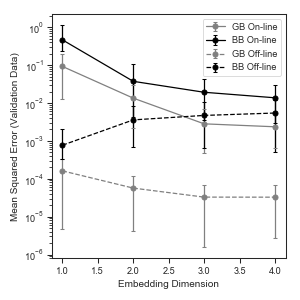

In [25]:


#eval_data = pd.DataFrame(columns = ['GB Off-line', 'BB Off-line', 'GB On-line', 'BB On-line',
#                                   'GB_OFF_STD', 'BB_OFF_STD', 'GB_ON_STD', 'BB_ON_STD',
#                                   'GB_OFF_LQ', 'BB_OFF_LQ', 'GB_ON_LQ', 'BB_ON_LQ',
#                                   'GB_OFF_UQ', 'BB_OFF_UQ', 'GB_ON_UQ', 'BB_ON_UQ',],
#                         index = lag_times,
#                         data=np.hstack([MSE_MEDIAN,MSE_STD,MSE_QUANTS[0].T,MSE_QUANTS[1].T]))

eval_data = pd.read_excel("mse_embed.xlsx", index_col=0, sheet_name="summary")

fig=plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax.semilogy(eval_data['GB On-line'],'-o',c='black')
#ax.semilogy(eval_data['Gline'],'-o',c='grey')
#ax.semilogy(eval_data['BB On-B Off-line'],'--o',c='grey')
#ax.semilogy(eval_data['BB Off-line'],'--o',c='black')
plt.errorbar(eval_data.index,eval_data['GB On-line'],yerr=np.array([eval_data['GB_ON_LQ'],eval_data['GB_ON_UQ']]), fmt='-o',c='grey',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['BB On-line'],yerr=np.array([eval_data['BB_ON_LQ'],eval_data['BB_ON_UQ']]), fmt='-o',c='black',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['GB Off-line'],yerr=np.array([eval_data['GB_OFF_LQ'],eval_data['GB_OFF_UQ']]), fmt='--o',c='grey',capsize=1.5)
plt.errorbar(eval_data.index,eval_data['BB Off-line'],yerr=np.array([eval_data['BB_OFF_LQ'],eval_data['BB_OFF_UQ']]), fmt='--o',c='black',capsize=1.5)

#ax.plot(x=training_points,y=eval_data['BB On-line'],'--o',c='black',label='asdfasdf')
#ax.plot(x=training_points,y=eval_data['GB Off-line'],ls='--o',c='grey',label='43434')
#ax.plot(x=training_points,y=eval_data['BB Off-line'],ls='--o',c='black',label='123412')
ax.set_yscale('log')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Mean Squared Error (Validation Data)')
plt.tight_layout()
#plt.ylim([1e-6,1e2])
plt.legend()
#plt.savefig('../figs/MM_variable_embed_dim.svg')

In [ ]:
N_train = 500
ze_k_train = tf.to_float(ze_k[0:N_train])
x_train    = tf.to_float(xs_k[1:N_train+1])
st_train   = sample_time_tensor[0:N_train]

ze_k_valid = tf.to_float(ze_k[N_train:-1])
x_valid    = tf.to_float(xs_k[N_train+1::])
st_valid   = sample_time_tensor[N_train:-1]

In [ ]:
#delete before retraining
try:
    del Balance_Model
except:
    pass
Balance_Model = gb_ann.CSTR_GB_ANN(theta,S0,mean_z,s_z,mean_phi,s_phi,lag_in_model,embed)
ft =  Balance_Model.fit([ze_k_train,st_train],x_train,
                        batch_size=50,
                        epochs=100,
                        verbose=0,
                        #validation_data=([ze_k_valid,st_valid], x_valid)
                        )
pd.DataFrame(ft.history).plot()

In [ ]:

try:
    del BlackBox
except:
    pass 
BlackBox = tf.keras.Model(inputs=bb_in,outputs=bb_next)
BlackBox.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),loss=tf.losses.mean_squared_error)
ft_bb =  BlackBox.fit(ze_k_train,x_train,
                        batch_size=50,
                        epochs=100,
                        verbose=0,
                        #validation_data = (ze_k_valid, x_valid)
                        )
pd.DataFrame(ft_bb.history).plot() 


In [ ]:
print(Balance_Model.CSTR_GB_ANN_model.evaluate([ze_k_valid,st_valid], x_valid))


In [ ]:
print(BlackBox.evaluate(ze_k_valid,x_valid))

In [ ]:
# Integrate the Model

history0 = tf.reshape(tf.to_float(ze_k[0,n_var::]),[1,embed*n_var-n_var])
xk0      = tf.reshape(tf.to_float(xs_k[0]),[1,1])
uk0      = tf.reshape(tf.to_float(us_k[0]),[1,1])

xkmodel = np.zeros([len(points),1])
history = np.zeros([len(points),embed*n_var-n_var])
xkmodel[0,:] = xk0
history[0,:] = history0

xkbbmodel = xkmodel.copy()
historybb = history.copy()
for i in range(len(points)):
    if i > 0:
        (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k[i-1],xkmodel[i-1],history[i-1])
        zek_bb = tf.reshape(tf.concat([tf.to_float(us_k[i-1]),
                           tf.to_float(xkbbmodel[i-1]),
                           tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
        xkbbmodel[i,:] = BlackBox(zek_bb)
        historybb[i] = zek_bb[:,0:embed*n_var-n_var]
phi_model = Balance_Model.constitutive_law(us_k,xkmodel,history)                                            

In [ ]:
print(np.mean((xkmodel[N_train::]-xs_k[N_train::])**2),
      np.mean((xkbbmodel[N_train::]-xs_k[N_train::])**2))

In [ ]:

'''
plt.figure(figsize=(4,4))
#plt.title('Model Performance on Training/Validation Data')
plt.plot(t_sim/60, (x_k-mean_x)/s_x,label='True System')
plt.plot(t_sim[points]/60,xkmodel,c='gray',label='Grey Box')
plt.plot(t_sim[points]/60,xkbbmodel,c='k', label='Black Box')
plt.ylabel(r'$x_c$')
plt.vlines(530/60,-2.25,2.25)
plt.text(150/60,-2,'Training')
plt.text(1200/60,-2,'Validation')
plt.xlabel('Time [min]')

plt.legend(loc='upper right')
'''
fig=plt.figure(figsize=(4,4))
ax1=fig.add_subplot(211)
ax1.plot(t_sim/60, (x_k-mean_x)/s_x,c=blue,label='True System')
ax1.plot(t_sim[points]/60,xkbbmodel,c='k', label='Black Box')
ax1.plot(t_sim[points]/60,xkmodel,c='gray',label='Grey Box')
ax1.vlines(530/60,-2.75,2.75)
#ax1.text(150/60,-1,'Training')
#ax1.text(1200/60,-1,'Validation')
ax1.set_ylabel(r'$x_c$')
#ax1.set_yticks([-1,0,1])
ax1.set_ylim(-2.75,2.75)
ax1.legend(loc='upper right')

ax2=fig.add_subplot(212,sharex=ax1)
ax2.plot(t_sim/60,(phi_on-mean_phi)/s_phi,c=blue,label='True System')
ax2.plot(t_sim[points]/60,phi_model,c='grey', label='Grey Box')
ax2.set_ylabel(r'$\phi$')
ax2.vlines(530/60,-2.75,2.75)
ax2.text(150/60,-2.5,'Training')
ax2.text(1200/60,-2.5,'Validation')
ax2.set_ylim([-2.75,2.75])
#ax2.set_yticks([-.5,0,0.5])

ax2.set_ylabel(r'$\phi$')
plt.xlabel('Time [min]')
plt.tight_layout()
fig.subplots_adjust(hspace=0)
#plt.savefig('../figs/MM_valid_plot.svg')


In [ ]:
Balance_Model.CSTR_GB_ANN_model.save('MM_model.h5')

In [ ]:
### INPUT SINE
# Data generation parameters
simulation_time_sine = 60*10             
sample_time_sine = 1   
N_online_steps_sine= int(simulation_time_sine/sample_time_sine)  # number of online measurements betweens steps

# All states full time series
x_on_sine = np.zeros((N_online_steps_sine,3))

# All states full time series
u_on_sine = np.zeros((N_online_steps_sine,1))

# Unknown, but to be learned, parameter
phi_on_sine = np.zeros((N_online_steps_sine,1))

t_sim_sine = np.linspace(0,simulation_time_sine,N_online_steps_sine)
def freq_fun(t):
    if t <2.5*60:
        return 5e-5*20*60/2*2
    elif t < 5*60:
        return 5e-5*(20*60)*2.5
    elif t < 7.5*60:
        return 5e-5*(20*60)*3
    else:
        return 0
    
plt.figure()
freq_ind = np.zeros(np.shape(t_sim_sine))
for i in range(len(t_sim_sine)):
    freq_ind[i] = freq_fun(t_sim_sine[i])
plt.plot(t_sim_sine/60, freq_ind)

In [ ]:


E0FUNSIN = lambda t : 2*np.cos(t*freq_fun(t))*s_u+mean_u

x0 = np.array([5e-2, 5e-2, 5e-3])
t_init = np.linspace(0,200,20)
x,infodict = spi.odeint(lambda x,t : ode(t,x,lambda t:.5e-2), x0,t_init,full_output=True)
x0 = x[-1]

integrator = spi.ode(lambda t,x : ode(t,x,E0_fun=E0FUNSIN))
integrator.set_initial_value(x0)
integrator.set_integrator('vode')


for i in range(N_online_steps_sine):
    if i > 0:
        integrator.integrate(t_sim_sine[i])

    #print(integrator.y)
    u_on_sine[i] = E0FUNSIN(t_sim_sine[i])
    #noise = np.random.normal(0,1,3)
    #noise = noise*(.02*x_on[i-1])
    x_on_sine[i] = integrator.y
    phi_on_sine[i] = kcat*integrator.y[2]/(Km+integrator.y[0])

    # collect data in format for GB-ANN model
n_var = 2 # 2 variables (E0 and S) in the model
x_k_sine = x_on_sine[:,0].reshape(N_online_steps_sine,1) # x_k = S[k]
u_k_sine = u_on_sine.reshape(N_online_steps_sine,1)      # u_k = E0[k]
z_k_sine = np.hstack([u_k_sine,x_k_sine])                # z_k = [u_k,x_k]
phi_k_sine = phi_on_sine.reshape(N_online_steps_sine,1)  # the (to be learned) rate constant

#mean_x   = np.mean(x_k)
#s_x      = np.std(x_k)
#mean_u   = np.mean(u_k)
#s_u      = np.mean(u_k)
#mean_z   = np.array([mean_u, mean_x])
#s_z      = np.array([s_u, s_x])
#mean_phi = np.mean(phi_k) # could use estimate here in absense of underlying data
#s_phi    = np.std(phi_k)

# standardize the data
xs_k_sine = (x_k_sine - mean_x)/s_x
us_k_sine = (u_k_sine - mean_u)/s_u
zs_k_sine = np.hstack([us_k_sine,xs_k_sine])
# embed the data
lag = 1
embed = 31

# for simple notation, use ze_k for standardized embedded z (don't need unstandardized form)
ze_k_sine = ut.embed_data(zs_k_sine,lag,embed)
points_sine = np.arange((embed-1)*lag,N_online_steps_sine)

# save sample time tensor
sample_time_tensor_sine = sample_time_sine*tf.ones([len(points_sine),1])

# discard data before enough collected for embedding
xs_k_sine = xs_k_sine[points_sine]
us_k_sine = us_k_sine[points_sine]
zs_k_sine = zs_k_sine[points_sine]  


In [ ]:
# Integrate the Model

history0 = tf.reshape(tf.to_float(ze_k_sine[0,n_var::]),[1,embed*n_var-n_var])
xk0      = tf.reshape(tf.to_float(xs_k_sine[0]),[1,1])
uk0      = tf.reshape(tf.to_float(us_k_sine[0]),[1,1])

xkmodel = np.zeros([len(points_sine),1])
history = np.zeros([len(points_sine),embed*n_var-n_var])
xkmodel[0,:] = xk0
history[0,:] = history0

xkbbmodel = xkmodel.copy()
historybb = history.copy()

for i in range(len(points_sine)):
    if i > 0:
        (xkmodel[i,:], history[i,:]) = Balance_Model.step(us_k_sine[i-1],xkmodel[i-1],history[i-1],step_size=1)
        zek_bb = tf.reshape(tf.concat([tf.to_float(us_k_sine[i-1]),
                           tf.to_float(xkbbmodel[i-1]),
                           tf.to_float(historybb[i-1])],axis=0),[1,n_var*embed])
        xkbbmodel[i,:] = BlackBox(zek_bb)
        historybb[i] = zek_bb[:,0:embed*n_var-n_var]
phi_model_sine = Balance_Model.constitutive_law(us_k_sine,xkmodel,history)  

In [ ]:

fig=plt.figure(figsize=(4,4))
ax1=plt.subplot(211)
ax1.plot(t_sim_sine/60,(x_on_sine[:,0]-mean_x)/s_x,c=blue)
ax1.plot(t_sim_sine[points_sine]/60,xkbbmodel.flatten(),c='k')
ax1.plot(t_sim_sine[points_sine]/60,xkmodel.flatten(),c='grey')
#plt.plot(t_sim,z_validates[:,1],'--',c='k')
ax1.set_ylabel(r'$x_c$')
ax1.set_ylim(-2.75,2.75)
plt.legend(['True System', 'Black Box', 'Grey Box'],loc='best')

ax2=plt.subplot(212,sharex=ax1)
ax2.plot(t_sim_sine/60,(u_on_sine-mean_u)/s_u,c=red)

#plt.plot(t_sim,z_validates[:,0],'--',c='k')
#plt.text(.28,.9,'Training',transform=ax.transAxes)
#plt.text(.77,.9,'Validation',transform=ax.transAxes)
ax2.set_ylim(-2.75,2.75)
ax2.set_ylabel('u')
#plt.ylim([0,.012])
#plt.vlines(1207,.0,1)
#plt.xlim([250,500])
#plt.legend(['True Data', 'Model Fit'],loc='upper left')
ax2.set_xlabel('Time [min]')
plt.tight_layout()
fig.subplots_adjust(hspace=0)
#plt.savefig("../figs/MM_different_inputs.svg")

#fig=plt.figure(figsize=(5,3))
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#axins=inset_axes(ax1,width=1.5,height=.3,bbox_to_anchor=(.85,.4),bbox_transform=ax1.transAxes)

#axins.plot(t_sim_sine/60,(x_on_sine[:,0]-mean_x)/s_x,c=blue)
#axins.plot(t_sim_sine[points_sine]/60,xkbbmodel.flatten(),c='k')
#axins.plot(t_sim_sine[points_sine]/60,xkmodel.flatten(),c='grey')
#plt.plot(t_sim,z_validates[:,1],'--',c='k')
#axins.set_ylabel(r'$x_c$')
#axins.set_ylim(-.5,.5)
#axins.set_xlim(50,60)



In [ ]:
t_sim_sine[0:10]

In [ ]:
20*60*3